<a href="https://colab.research.google.com/github/avinashnanda/Fake_news/blob/main/Fake_news_RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages and load the data.

In [6]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from contractions import CONTRACTION_MAP
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import f1_score,precision_score,recall_score
import matplotlib
nltk.download('punkt')
from scipy import sparse
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import unicodedata
plt.rcParams['figure.figsize'] = (10,12 )
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["legend.loc"] = 'best'
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")

In [8]:
test = pd.read_csv("/content/drive/MyDrive/test.csv")

# Check the dataset size and dependent variable distribution.


*   There is no class imbalance.



In [9]:
print(train.shape)
print(test.shape)

(20800, 5)
(5200, 4)


In [10]:
train["label"].value_counts()

1    10413
0    10387
Name: label, dtype: int64

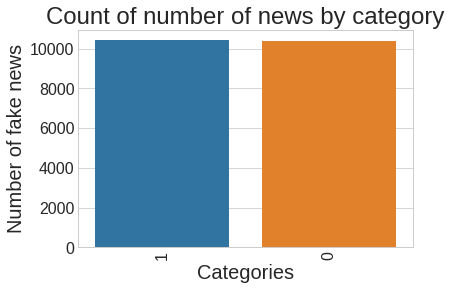

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(data = train,x="label",order = train['label'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Categories')
plt.ylabel('Number of fake news')
plt.title('Count of number of news by category')
plt.show()


# Analyzing and imputing NA

* Impute Na with Unknown string

In [12]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [13]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [14]:
train.fillna('Unknown',inplace=True)
test.fillna('Unknown',inplace=True)

# **Define Helper Functions and Text preprocessing.**


*   Defined my helper functions to do preprocessing like stop word removal,special character removal,lemmatization,word contractions and beautiful confusion matrix.
* Combined title and author columns.
*   Cleaned the text and appended to the respective dataframe for further processing.

In [35]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap = sns.color_palette("summer"),cbar=False,linewidths=2, linecolor='black',annot_kws={"size":20})
    plt.savefig(filename)

In [15]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+')
    return url_pattern.sub(r'', str(text))

In [16]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [17]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [18]:
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[]^_`{|}~'
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [19]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [20]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_text(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [21]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,url_remove =True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True,tokenize=True):
    
    normalized_corpus = []
    tokenized_texts = []
    # normalize each document in the corpus
    for doc in tqdm(corpus):
        # strip HTML
        if url_remove:
            doc = remove_urls(doc)
#         if html_stripping:
#             doc = remove_html(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
          
        # lowercase the text 
        if text_lower_case:
          doc = doc.lower()
        # expand contractions    
        if contraction_expansion:
          doc = expand_contractions(doc)
        # remove extra newlines

        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # map u.s to usa
        doc = re.sub(r'u.s.', 'usa',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.\[(-):!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
            doc = remove_punctuation(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
      
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        # change \\n to \n
        doc = re.sub("\\\\n","\n",doc)
                  
        normalized_corpus.append(doc)
        
        if tokenize:
             tokens = tokenizer.tokenize(doc)
        tokenized_texts.append(tokens)
        
    return normalized_corpus,tokenized_texts

In [22]:
train['total_text']=train['title']+train['author']
test['total_text']=test['title']+test['author']

In [23]:
a,b = normalize_corpus(test["total_text"])
test["clean_total_text"] = a
a,b = normalize_corpus(train["total_text"])
train["clean_total_text"] = a

100%|██████████| 20800/20800 [00:31<00:00, 663.16it/s]


# Deep Learning model

* Split the train dataset to train and validation.
* Defined a bidirection GRU model for training.
* Used early stopping and model checkpoint callbacks.





In [25]:
import gc
import sys
import keras
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [26]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, yvalid = train_test_split(train, 
                                                  train['label'],  
                                                  random_state=42, 
                                                  test_size=0.2)

In [27]:
wordcounts = []
for sentence in xtrain["clean_total_text"]:
  words = sentence.split(' ')
  wordcounts.append(len(words))
  average_wordcount = sum(wordcounts)/len(wordcounts)
average_wordcount

9.61905048076923

In [28]:
from collections import Counter
cnt = Counter()
for text in train["clean_total_text"].values:
    for word in text.split():
        cnt[word] += 1
len(cnt.keys())

30491

In [29]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 30 # max number of words in a question to use

## fill up the missing values
train_X = xtrain["clean_total_text"].fillna("_na_").values
val_X = xvalid["clean_total_text"].fillna("_na_").values
test_X = test["clean_total_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [30]:
train_y = np.array(xtrain["label"])
val_y = np.array(xvalid["label"])

In [31]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           9000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           330240    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129   

In [32]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
def callbacks():
  checkpoint = ModelCheckpoint(
      'model.h5', 
      monitor='val_accuracy', 
      verbose=1, 
      save_best_only=True, 
      mode='auto'
  )

  early_stop = EarlyStopping(
          monitor     = 'val_accuracy', 
          patience    = 10, 
          mode        = 'auto', 
          verbose     = 1,
      restore_best_weights = True
      
      )
  return checkpoint,early_stop

checkpoint,early_stop = callbacks()

In [33]:
## Train the model 

history =  model.fit(train_X,train_y, batch_size=256, epochs=50,validation_data=(val_X, val_y),callbacks = [checkpoint,early_stop])

Epoch 1/50
65/65 [==============================] - 62s 600ms/step - loss: 0.4523 - accuracy: 0.8060 - val_loss: 0.0439 - val_accuracy: 0.9870

Epoch 00001: val_accuracy improved from -inf to 0.98702, saving model to model.h5
Epoch 2/50
65/65 [==============================] - 37s 562ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0360 - val_accuracy: 0.9906

Epoch 00002: val_accuracy improved from 0.98702 to 0.99063, saving model to model.h5
Epoch 3/50
65/65 [==============================] - 39s 595ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0480 - val_accuracy: 0.9868

Epoch 00003: val_accuracy did not improve from 0.99063
Epoch 4/50
65/65 [==============================] - 37s 569ms/step - loss: 1.1364e-04 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9861

Epoch 00004: val_accuracy did not improve from 0.99063
Epoch 5/50
65/65 [==============================] - 37s 569ms/step - loss: 6.2581e-05 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9

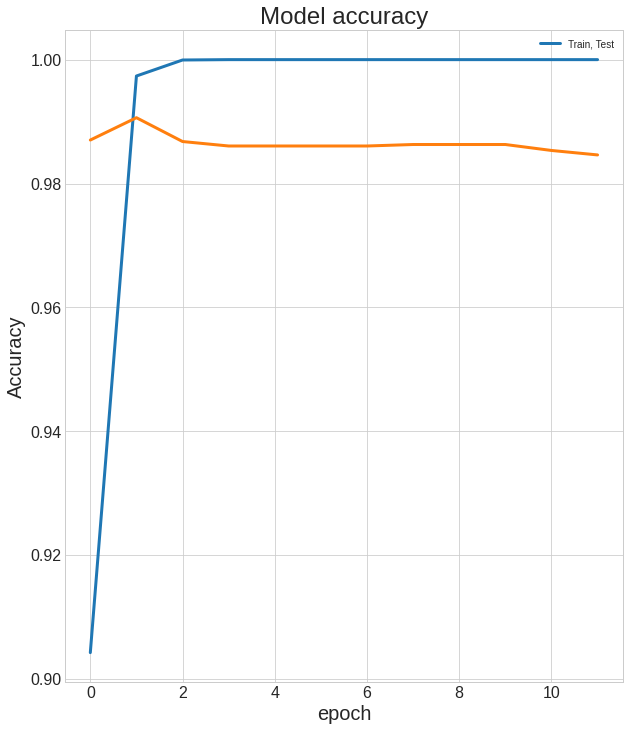

In [40]:
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train, Test'], loc=0)

plot_acc(history)
plt.show()


The model f1 score on the val set is 0.99041.
The model precision on the val set is 0.98822.
The model recall on the val set is 0.99260.


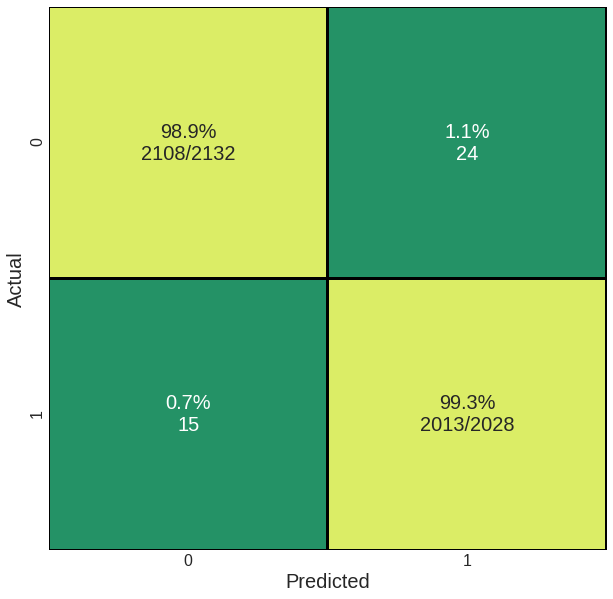

In [36]:
val_pred = model.predict(val_X)
val_pred = (val_pred > 0.5).astype('int64')
val_pred = val_pred.reshape((4160,))
print('The model f1 score on the val set is {:.5f}.'.format(f1_score(yvalid, val_pred)))
print('The model precision on the val set is {:.5f}.'.format(precision_score(yvalid, val_pred)))
print('The model recall on the val set is {:.5f}.'.format(recall_score(yvalid, val_pred)))
cm_analysis(xvalid["label"], val_pred, "abc.jpg",labels=[0,1], ymap={0:'0',1: '1'}, figsize=(10,10))

In [37]:
y_pred = model.predict(test_X)
y_pred = (y_pred > 0.5).astype('int64')
y_pred = y_pred.reshape((y_pred.shape[0],))
sub = pd.read_csv("/content/drive/MyDrive/submit.csv")
sub["label"]= y_pred
sub.to_csv("submission_lstm_v1.csv",index=None)

* Private Score: 0.99313
*	Public Score: 0.99102
